<a href="https://colab.research.google.com/github/fake-news-unal/fake-news/blob/main/K_means%2Clogistica%2Cbosque%2Carbol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importar librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Importar keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

# Para la matrix de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import sqlite3

In [2]:
isqlite_db = "./dataset/fake_news.sqlite"

conn = sqlite3.connect(sqlite_db)
df = pd.read_sql_query("SELECT * FROM NEWS", conn)
conn.close()

In [ ]:
df_news['original'] = df_news['title'] + '. ' + df_news['text']
df_news['original'].replace("..", ".")

#### Total de palabras en el Dataset

In [3]:
list_of_words = []
unique_words = set()
for document in df_news.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844981 unique_words:96148


### Partición del dataset

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [26]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [27]:
print("Texto original (limpio) \n",df.clean_joined[0],"\n Texto Tokenizado : ",train_sequences[0])

Texto original (limpio) 
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats sayi

### Word2vec (Vectorización)

In [28]:
#Importando librerías
import string # python library
import re # regex library
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

In [30]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

processed_data = []
processed_labels = []

for index, row in df.iterrows():
    words_broken_up = preprocess_string(row['original'], CUSTOM_FILTERS)
    # Esto elimina cualquier campo que pueda quedar en blanco después del preprocesamiento.
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['isfake'])

In [31]:
model = Word2Vec(processed_data, min_count=1)

In [32]:
model.wv.most_similar("country")

[('nation', 0.8089867234230042),
 ('america', 0.6789793968200684),
 ('countries', 0.5719372034072876),
 ('country’s', 0.5464644432067871),
 ('america’s', 0.5421832203865051),
 ('abroad', 0.5278910994529724),
 ('planet', 0.5154141187667847),
 ('world', 0.5134656429290771),
 ('europe', 0.504770815372467),
 ('region', 0.5009129047393799)]

In [ ]:
# Obtener el vector de una oración basado en el promedio de todos los vectores de palabras en la oración
# Obtenemos el promedio ya que esto representa diferentes longitudes de oraciones
def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))


In [35]:
X_np = np.array(X)
X_np.shape

(44898, 100)

# ***K-means***

In [36]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
Iteration 0, inertia 737085.4642621779
Iteration 1, inertia 430252.5112915458
Iteration 2, inertia 416478.47767837544
Iteration 3, inertia 411966.58050349477
Iteration 4, inertia 410156.75438470504
Iteration 5, inertia 409232.76161763835
Iteration 6, inertia 408736.1501167476
Iteration 7, inertia 408485.4472621273
Iteration 8, inertia 408367.74439123995
Iteration 9, inertia 408313.1192793781
Iteration 10, inertia 408289.3516001077
Iteration 11, inertia 408282.819951838
Iteration 12, inertia 408280.8158285033
Iteration 13, inertia 408279.83288103034
Iteration 14, inertia 408279.2053512189
Converged at iteration 14: center shift 7.883456039564062e-06 within tolerance 1.0467464690183695e-05.
Initialization complete
Iteration 0, inertia 909126.1564107364
Iteration 1, inertia 410811.13374412927
Iteration 2, inertia 408933.2824742384
Iteration 3, inertia 408499.537115448
Iteration 4, inertia 408356.5827655159
Iteration 5, inertia 408305.60133145505
Iteration 6, inerti

In [37]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[budget, fight, looms, republicans, flip, fisc...",1,1
1,"[military, accept, transgender, recruits, mond...",1,1
2,"[senior, republican, senator, let, mueller, jo...",1,1
3,"[fbi, russia, probe, helped, australian, diplo...",1,1
4,"[trump, wants, postal, service, charge, amazon...",1,1
5,"[white, house, congress, prepare, talks, spend...",1,1
6,"[trump, says, russia, probe, fair, timeline, u...",1,1
7,"[factbox, trump, twitter, dec, approval, ratin...",1,0
8,"[trump, twitter, dec, global, warming, followi...",1,0
9,"[alabama, official, certify, senator, elect, j...",1,0


In [38]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 83.46696957548221%


In [39]:
# PCA 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [41]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

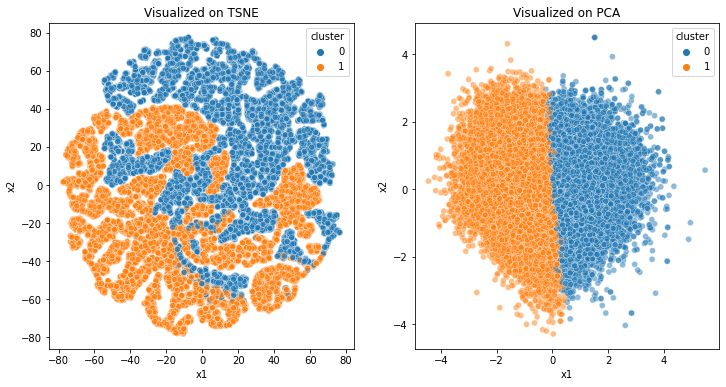

In [42]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')